# The diffusion
---

In this section we will look at how to model diffusion

## Space but no diffusion


As previously, we will start with simpler examples by reducing our space to 1 dimension and by not having diffusion.

So the first exercice is to write a `class` that models interdependent activator and inhibitor concentrations as before but for a row of cells (so 1 dimension) instead of just one single cell.

To do so we will use a `ndarray` with 2 dimensions: one for space and one for time.

You have to write a `class` with a `run` method that runs the model until time `T` with the $\delta t$ specified by `dt`.

Each steps of the run should be stored in two `ndarray`s named `A` and `I`.

In [ ]:
from turing_models import TuringInit
import numpy as np


class Turing(TuringInit):
    def reaction_A(self, a, i):
        return a - a**3 - i + self.k
    
    def reaction_I(self, a, i):
        return a - i

    def run(self):
        for t in range(self.n-1):
            a = self.A[t]
            i = self.I[t]
            self.A[t+1] = a + self.dt * self.reaction_A(a, i)
            self.I[t+1] = i + self.dt/self.tau * self.reaction_I(a, i)

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        np.random.seed(0)
        self.A = np.zeros((self.n, self.size))
        self.A[0] = np.random.random(self.size)
        self.I = np.zeros((self.n, self.size))
        self.I[0] = np.random.random(self.size)


model = Turing()
model.run()
model.plot_reactions(step=50)

## Diffusion in one dimension

Instead of having one single cell in our model, we will have a row of cells that are communicating with each others.

The communication can be described for the activator by:

$$\frac{\delta a}{\delta t} = \mu_a \nabla a$$

and, for the inhibitor by:

$$\tau\frac{\delta i}{\delta t} = \mu_i \nabla i$$

Now, the question is: how do we model $\nabla\bullet$??

Well, the idea is that a given cell, at a position $x$ receives, via diffusion, content from its direct neighbouring cells at positions $x-\delta x$ and $x + \delta x$.

That same cell gives content, also via diffusion, to the same neighbours at positions $x-\delta x$ and $x + \delta x$.

How much a cell receives from its neighbours is modulated by the parameters $\mu_a$ for the activator and $\mu_i$ for the inhibitor. $\mu_a=0$ means that there is no diffusion for the activator, $\mu_a=1$ means that the cells give all their content to their neighbours and a $\mu_a=0.25$ means that the cells give $25\%$ of their content to their neighbourhing cells.

⚠️ One has to be careful though, since $\mu_a$ models how much a cell give to **1** of its neighbors, if $\mu_a*\#neighbs>1$ then the cell will diffuse more than it has, which is physically not possible.⚠️

That being said, we can now model $\nabla a$ diffusion as follow:
$$
\nabla a = \frac{a_{x-\delta x, t} + a_{x+\delta x, t} - 2a_{x, t}}{\delta x}
$$
And so the change of concentration due to diffusion for a cell at the position $x$ at time $t$ becomes:
$$
\frac{\delta a_{x, t}}{\delta t} = \mu_a . \frac{a_{x-\delta x, t} + a_{x+\delta x, t} - 2a_{x, t}}{\delta x}
$$
(similarly for $i$).

And therefore the concentration at $t+\delta t$ after diffusion is the following:
$$
a_{x, t+\delta t} = a_{x, t} + \delta t . \mu_a . \frac{a_{x-\delta x, t} + a_{x+\delta x, t} - 2a_{x, t}}{\delta x}
$$

<img src="../Images/Diffusion.png" alt="Diffusion" width="500"/>


## How to compute diffusion in a 1D row.

Let:
- `A` be a `np.ndarray` that contains the concentration of the activator `A` for our row of cells.
- `A[t]` is the concentration of the cells at time `t`.
- `A[t, i]` is the concentration of the `i`th cell at time `t`.

The question is: knowing `A[t]` how do we compute `A[t+1]`?

From the previous equations, we know the following:

`A[t+1, i] = A[t, i] + (dt/dx)*mu_a*(A[t, i-1] + A[t, i+1] - 2*A[t, i])`

Now, we can run the previous line of code for each cell at `t+1`, then `t+2` and so on and so forth. Of course, provided that we have `A[0]`.

### Exercices:

Write a function that takes as an input `A[t]` and returns `A[t+1]`.

Remember that `A[t]` is a 1 dimensional `np.ndarray`: `A[t].shape = (nb_cells, )`

In [ ]:
import numpy as np


def next_time(A, mu, dt, dx, tau):
    """
    Given a row of concentrations at time t, computes the concentrations at time t+dt
    """
    next_A = A.copy()
    next_A[1:-1] = (dt*mu*dx)/tau * A[2:] + A[:-2] - 2*A[1:-1]
    # Note that in that implementation, the border of the array (A[0] and A[-1]) are kept constant
    return next_A

Integrate that function into your class

In [ ]:
from turing_models import TuringInit
import numpy as np


class Turing(TuringInit):

    def diffusion(self, arr, mu, dx):
        next_arr = arr.copy()
        next_arr[0] = dx * mu * (arr[1] - arr[0])
        next_arr[-1] = dx * mu * (arr[-2] - arr[-1])
        next_arr[1:-1] = dx * mu * (arr[2:] + arr[:-2] - 2*arr[1:-1])
        return next_arr

    def run(self):
        for t in range(self.n-1):
            a = self.A[t]
            i = self.I[t]
            self.A[t+1] = a + self.dt * self.diffusion(a, self.mu_a, self.dx)
            self.I[t+1] = i + self.dt/self.tau * self.diffusion(i, self.mu_i, self.dx)

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        np.random.seed(0)
        self.A = np.zeros((self.n, self.size))
        self.A[0] = np.random.random(self.size)
        self.I = np.zeros((self.n, self.size))
        self.I[0] = np.random.random(self.size)


model = Turing()
model.run()
model.plot_reactions(step=100)

**If you are struggling (it is not easy) you can try to separate diffusion from reaction**

In other words we are trying to implement the following equations:

$$
a_{x, t+1} = a_{x, t} + \delta t * (\mu_a\nabla a + a - a^3 - i + k)
$$

and

$$
i_{x, t+1} = i_{x, t} + \frac{\delta t}{\tau} * (\mu_i\nabla i + a - i)
$$

But you can separate the diffusion from the reaction, if you have a function for the diffusion (let say `diffusion`) and a function for the reaction (let say `reaction`) you can compute the concentration at the next time the following way:

```python
a[t+1] = a[t] + dt * (diffusion(a[t]) + reaction(a[t]))
i[t+1] = i[t] + dt/tau * (diffusion(i[t]) + reaction(i[t]))
```

Also, be careful of side effects!!

## From 1D to 2D

Now that we know how to code a model in 1D over time, we can go directly to 2D 😨

That being said, we will use the 2D convolution seen before to our advantage. Indeed, in the diffusion each cell receive activator and inhibitor from its neighbours and give back to its neighbours.

So the diffusions can be computed as follow:
$$
\mu * (\sum Neighbs~concentration - \#neighbs * own~concentration)
$$

We already know how to compute the number of neighbours with the convolution and therefore we are able to compute $\#neighbs * own~concentration$

And to compute the $\sum Neighbs~concentration$ we can also use a convolution:

<img src="../Images/ConvolDiffusion.png" alt="Diffusion" width="1000"/>

You now have everything you need

In [1]:
from turing_models import TuringInit
import numpy as np
from scipy.ndimage import convolve


class Turing(TuringInit):
    kernel = [
        [0, 1, 0],
        [1, 0, 1],
        [0, 1, 0],
    ]

    def diffusion(self, arr, mu):
        income = convolve(arr, self.kernel, mode='constant', cval=0)
        outcome = self.neighbours*arr
        return mu * (income - outcome) / (self.dx * self.dy)
    
    def reaction_A(self, a, i):
        return a - a**3 - i + self.k
    
    def reaction_I(self, a, i):
        return a - i

    def run(self):
        for t in range(self.n-1):
            a = self.A[t].copy()
            i = self.I[t].copy()
            self.A[t+1] = a + self.dt * (self.diffusion(a, self.mu_a) + self.reaction_A(a, i))
            self.I[t+1] = i + self.dt * (self.diffusion(i, self.mu_i) + self.reaction_I(a, i)) / self.tau

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        np.random.seed(0)
        self.A = np.zeros((self.n, self.size, self.size))
        self.A[0] = np.random.random((self.size, self.size))*2 - 1
        self.I = np.zeros((self.n, self.size, self.size))
        self.I[0] = np.random.random((self.size, self.size))*2 - 1
        self.neighbours = convolve(np.ones_like(self.A[0]), self.kernel, mode='constant', cval=0)

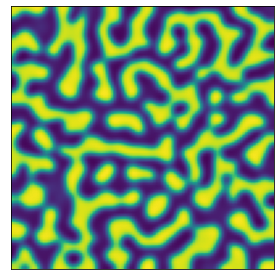

In [2]:
model = Turing()
model.run()
model.plot_reactions()
# model.save3D("Parameters.gif", nb_steps=200) # <- You can use that to save your result as a gif

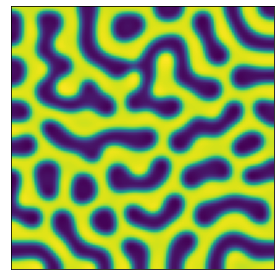

In [3]:
# Using a different set of parameters
model = Turing(
    mu_a = 2.8e-4,
    mu_i = 5e-3,
    T = 60,
    dt = .01,
    tau = 3,
    k = .05,
    size = 100,
)
model.run()
model.plot_reactions()
# model.save3D("Parameters2.gif", nb_steps=200)

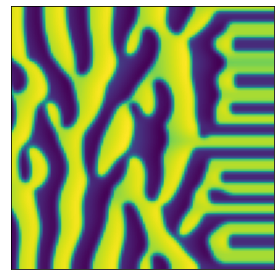

In [4]:
# Implementing anisotropic diffusion

model = Turing(
    mu_a = 2.8e-4,
    mu_i = 5e-3,
    T = 60,
    dt = .01,
    tau = 3,
    k = .05,
    size = 100,
    kernel = [
        [0, .5, 0],
        [1,  0, 0],
        [0, .5, 0],
    ]
)
model.run()
model.plot_reactions()
# model.save3D("anisotropic_diffusion.gif", nb_steps=200)

In [17]:
# Adding a "tube like" effect, ie the left and right hand part of the grid communicate
class TuringTube(Turing):
    def run(self):
        for t in range(self.n-1):
            a = self.A[t].copy()
            i = self.I[t].copy()
            self.A[t+1] = a + self.dt * (self.diffusion(a, self.mu_a) + self.reaction_A(a, i))
            self.I[t+1] = i + self.dt * (self.diffusion(i, self.mu_i) + self.reaction_I(a, i)) / self.tau
            tmpA = self.A[t+1, :, -1].copy()
            tmpI = self.I[t+1, :, -1].copy()
            self.A[t+1, :, -1] = self.A[t+1, :, 0]
            self.I[t+1, :, -1] = self.I[t+1, :, 0]
            self.A[t+1, :, 0] = tmpA
            self.I[t+1, :, 0] = tmpI

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

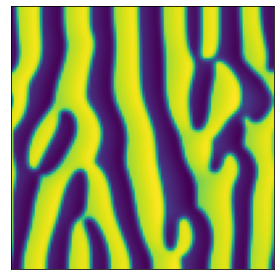

In [18]:
model = TuringTube(
    mu_a = 2.8e-4,
    mu_i = 5e-3,
    T = 100,
    dt = .01,
    tau = 3,
    k = .05,
    size = 100,
    kernel = [
        [0, .5, 0],
        [1,  0, 0],
        [0, .5, 0],
    ]
)
model.run()
model.plot_reactions()
model.save3D("tube.gif", nb_steps=200)